# SEO Content Quality & Duplicate Detector

This notebook implements a complete machine learning pipeline for analyzing web content quality and detecting duplicates. The system processes HTML content, extracts features, and builds a classification model to score content quality.

## Project Overview
- **Parse HTML content** from provided dataset
- **Extract text features** including readability scores and keywords
- **Detect duplicate content** using similarity algorithms
- **Build quality classification model** with performance evaluation
- **Provide real-time analysis** for new URLs

## Dataset
We're using the primary dataset with pre-scraped HTML content (data.csv) containing ~70 URLs with their HTML content.

## 1. Environment Setup and Data Loading

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import re
import json
import pickle
import warnings
warnings.filterwarnings('ignore')

# HTML parsing
from bs4 import BeautifulSoup
import requests
import time

# Text processing
import textstat
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics.pairwise import cosine_similarity

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

print("All libraries imported successfully!")
print("Python environment ready for SEO content analysis.")


All libraries imported successfully!
Python environment ready for SEO content analysis.


In [2]:
# Load the dataset
print("Loading dataset...")
df = pd.read_csv('../data.csv')

print(f"Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"First few URLs:")
for i, url in enumerate(df['url'].head(3)):
    print(f"  {i+1}. {url}")

# Check for missing values
print(f"\nMissing values:")
print(df.isnull().sum())

Loading dataset...
Dataset loaded successfully!
Shape: (81, 2)
Columns: ['url', 'html_content']
First few URLs:
  1. https://www.cm-alliance.com/cybersecurity-blog
  2. https://www.varonis.com/blog/cybersecurity-tips
  3. https://www.cisecurity.org/insights/blog/11-cyber-defense-tips-to-stay-secure-at-work-and-home

Missing values:
url              0
html_content    12
dtype: int64


## 2. HTML Content Parsing and Text Extraction

In [3]:
def extract_content_from_html(html_content):
    """
    Extract title, body text, and word count from HTML content.
    Returns a dictionary with extracted information.
    """
    try:
        # Parse HTML with BeautifulSoup
        soup = BeautifulSoup(html_content, 'html.parser')
        
        # Extract title
        title_tag = soup.find('title')
        title = title_tag.get_text().strip() if title_tag else "No Title"
        
        # Remove script and style elements
        for script in soup(["script", "style"]):
            script.decompose()
        
        # Extract text from main content areas
        body_text = ""
        
        # Try to find main content in common tags
        content_tags = soup.find_all(['p', 'article', 'main', 'div', 'section'])
        for tag in content_tags:
            text = tag.get_text()
            if len(text.strip()) > 20:  # Only add meaningful text blocks
                body_text += text + " "
        
        # If no content found, use body text
        if not body_text.strip():
            body = soup.find('body')
            body_text = body.get_text() if body else soup.get_text()
        
        # Clean the text
        body_text = re.sub(r'\s+', ' ', body_text).strip()
        
        # Calculate word count
        word_count = len(body_text.split()) if body_text else 0
        
        return {
            'title': title,
            'body_text': body_text,
            'word_count': word_count
        }
    
    except Exception as e:
        print(f"Error parsing HTML: {str(e)}")
        return {
            'title': "Parse Error",
            'body_text': "",
            'word_count': 0
        }

print("HTML parsing function created successfully!")

HTML parsing function created successfully!


In [4]:
# Process all HTML content and extract information
print("Processing HTML content...")
extracted_data = []

for idx, row in df.iterrows():
    url = row['url']
    html_content = row['html_content']
    
    # Extract content from HTML
    content_info = extract_content_from_html(html_content)
    
    # Create record
    record = {
        'url': url,
        'title': content_info['title'],
        'body_text': content_info['body_text'],
        'word_count': content_info['word_count']
    }
    
    extracted_data.append(record)
    
    if (idx + 1) % 10 == 0:
        print(f"Processed {idx + 1} pages...")

# Create DataFrame with extracted content
content_df = pd.DataFrame(extracted_data)

print(f"\nExtraction completed!")
print(f"Successfully processed {len(content_df)} pages")
print(f"Average word count: {content_df['word_count'].mean():.1f}")

# Show sample of extracted content
print(f"\nSample extracted content:")
print(content_df[['url', 'title', 'word_count']].head(3))

Processing HTML content...
Error parsing HTML: Incoming markup is of an invalid type: nan. Markup must be a string, a bytestring, or an open filehandle.
Processed 10 pages...
Error parsing HTML: Incoming markup is of an invalid type: nan. Markup must be a string, a bytestring, or an open filehandle.
Error parsing HTML: Incoming markup is of an invalid type: nan. Markup must be a string, a bytestring, or an open filehandle.
Processed 20 pages...
Error parsing HTML: Incoming markup is of an invalid type: nan. Markup must be a string, a bytestring, or an open filehandle.
Error parsing HTML: Incoming markup is of an invalid type: nan. Markup must be a string, a bytestring, or an open filehandle.
Processed 30 pages...
Processed 40 pages...
Error parsing HTML: Incoming markup is of an invalid type: nan. Markup must be a string, a bytestring, or an open filehandle.
Error parsing HTML: Incoming markup is of an invalid type: nan. Markup must be a string, a bytestring, or an open filehandle.
Pro

In [5]:
# Save extracted content to CSV (without HTML content to reduce file size)
content_df.to_csv('../data/extracted_content.csv', index=False)
print("Extracted content saved to '../data/extracted_content.csv'")

Extracted content saved to '../data/extracted_content.csv'


## 3. Text Preprocessing and Feature Engineering

In [6]:
def extract_features(text):
    """
    Extract comprehensive features from text content.
    Returns dictionary with readability, keywords, and other metrics.
    """
    try:
        if not text or len(text.strip()) == 0:
            return {
                'sentence_count': 0,
                'flesch_reading_ease': 0,
                'top_keywords': '',
                'avg_word_length': 0
            }
        
        # Clean text
        clean_text = re.sub(r'\s+', ' ', text.lower().strip())
        
        # Calculate sentence count
        sentences = re.split(r'[.!?]+', text)
        sentence_count = len([s for s in sentences if s.strip()])
        
        # Calculate Flesch Reading Ease score
        flesch_score = textstat.flesch_reading_ease(text)
        
        # Calculate average word length
        words = clean_text.split()
        avg_word_length = sum(len(word) for word in words) / len(words) if words else 0
        
        return {
            'sentence_count': sentence_count,
            'flesch_reading_ease': flesch_score,
            'avg_word_length': avg_word_length
        }
    
    except Exception as e:
        print(f"Error extracting features: {str(e)}")
        return {
            'sentence_count': 0,
            'flesch_reading_ease': 0,
            'avg_word_length': 0
        }

def extract_keywords_tfidf(texts, n_keywords=5):
    """
    Extract top keywords using TF-IDF vectorization.
    """
    try:
        # Remove empty texts
        valid_texts = [text for text in texts if text and len(text.strip()) > 10]
        
        if len(valid_texts) < 2:
            return [''] * len(texts)
        
        # Initialize TF-IDF vectorizer
        tfidf = TfidfVectorizer(
            max_features=1000,
            stop_words='english',
            ngram_range=(1, 2),
            min_df=2,
            max_df=0.8
        )
        
        # Fit TF-IDF on valid texts
        tfidf_matrix = tfidf.fit_transform(valid_texts)
        feature_names = tfidf.get_feature_names_out()
        
        # Extract keywords for each text
        keywords_list = []
        valid_idx = 0
        
        for text in texts:
            if text and len(text.strip()) > 10:
                # Get TF-IDF scores for this document
                doc_tfidf = tfidf_matrix[valid_idx].toarray()[0]
                
                # Get top keywords
                top_indices = doc_tfidf.argsort()[-n_keywords:][::-1]
                top_keywords = [feature_names[i] for i in top_indices if doc_tfidf[i] > 0]
                
                keywords_list.append('|'.join(top_keywords[:n_keywords]))
                valid_idx += 1
            else:
                keywords_list.append('')
        
        return keywords_list
    
    except Exception as e:
        print(f"Error extracting keywords: {str(e)}")
        return [''] * len(texts)

print("Feature extraction functions created successfully!")

Feature extraction functions created successfully!


In [7]:
# Extract features for all content
print("Extracting features from content...")

features_data = []

# Extract basic features for each page
for idx, row in content_df.iterrows():
    text = row['body_text']
    
    # Extract features
    features = extract_features(text)
    
    # Create feature record
    feature_record = {
        'url': row['url'],
        'word_count': row['word_count'],
        'sentence_count': features['sentence_count'],
        'flesch_reading_ease': features['flesch_reading_ease'],
        'avg_word_length': features['avg_word_length']
    }
    
    features_data.append(feature_record)

# Extract keywords using TF-IDF
print("Extracting keywords using TF-IDF...")
keywords_list = extract_keywords_tfidf(content_df['body_text'].tolist())

# Add keywords to features
for i, keywords in enumerate(keywords_list):
    features_data[i]['top_keywords'] = keywords

# Create features DataFrame
features_df = pd.DataFrame(features_data)

print(f"Feature extraction completed!")
print(f"Features extracted for {len(features_df)} pages")
print(f"\nFeature summary:")
print(features_df[['word_count', 'sentence_count', 'flesch_reading_ease']].describe())

Extracting features from content...
Extracting keywords using TF-IDF...
Feature extraction completed!
Features extracted for 81 pages

Feature summary:
          word_count  sentence_count  flesch_reading_ease
count      81.000000       81.000000            81.000000
mean    29586.407407     2086.419753            24.942706
std     39523.204690     4180.742589            24.734314
min         0.000000        0.000000           -29.331778
25%      2656.000000      149.000000             3.650417
50%     19956.000000     1094.000000            25.683542
75%     44108.000000     2340.000000            39.067610
max    276714.000000    32868.000000           102.522048


In [35]:
# Generate embeddings using Sentence Transformers
print("Generating embeddings using Sentence Transformers...")

# Initialize the model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Prepare texts for embedding (use title + body text for better representation)
embedding_texts = []
for idx, row in content_df.iterrows():
    # Combine title and body text, limit length for efficiency
    combined_text = f"{row['title']} {row['body_text']}"
    # Limit text length to 2048 characters for better content representation
    embedding_texts.append(combined_text[:2048])

# Generate embeddings
embeddings = model.encode(embedding_texts, show_progress_bar=True)

# Add embeddings to features DataFrame
features_df['embedding'] = [embedding.tolist() for embedding in embeddings]

print(f"Embeddings generated successfully!")
print(f"Embedding dimension: {embeddings.shape[1]}")
print(f"Using 2048 character limit for better similarity detection")

Generating embeddings using Sentence Transformers...


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Embeddings generated successfully!
Embedding dimension: 384
Using 2048 character limit for better similarity detection


In [36]:
# Save features to CSV
features_df.to_csv('../data/features.csv', index=False)
print("Features saved to '../data/features.csv'")

# Show sample features
print(f"\nSample features:")
sample_features = features_df[['url', 'word_count', 'flesch_reading_ease', 'top_keywords']].head(3)
for idx, row in sample_features.iterrows():
    print(f"\nURL: {row['url']}")
    print(f"Word Count: {row['word_count']}")
    print(f"Readability: {row['flesch_reading_ease']:.1f}")
    print(f"Keywords: {row['top_keywords'][:50]}...")

Features saved to '../data/features.csv'

Sample features:

URL: https://www.cm-alliance.com/cybersecurity-blog
Word Count: 47442
Readability: 30.1
Keywords: cyber|cybersecurity|september 2025|incident|septem...

URL: https://www.varonis.com/blog/cybersecurity-tips
Word Count: 20363
Readability: 30.8
Keywords: data|security|cloud|risk|access...

URL: https://www.cisecurity.org/insights/blog/11-cyber-defense-tips-to-stay-secure-at-work-and-home
Word Count: 16000
Readability: 21.9
Keywords: cybersecurity|password|secure|security|cyber...


## 4. Duplicate Content Detection

In [37]:
# Compute cosine similarity matrix
print("Computing cosine similarity for duplicate detection...")

# Convert embeddings to numpy array
embeddings_array = np.array([np.array(emb) for emb in features_df['embedding']])

# Compute cosine similarity matrix
similarity_matrix = cosine_similarity(embeddings_array)

# Set similarity threshold for duplicates
SIMILARITY_THRESHOLD = 0.80

print(f"Similarity matrix computed: {similarity_matrix.shape}")
print(f"Using similarity threshold: {SIMILARITY_THRESHOLD}")

# Find duplicate pairs
duplicate_pairs = []
n_pages = len(features_df)

for i in range(n_pages):
    for j in range(i + 1, n_pages):
        similarity = similarity_matrix[i][j]
        if similarity > SIMILARITY_THRESHOLD:
            duplicate_pairs.append({
                'url1': features_df.iloc[i]['url'],
                'url2': features_df.iloc[j]['url'],
                'similarity': round(similarity, 3)
            })

print(f"Found {len(duplicate_pairs)} duplicate pairs above threshold {SIMILARITY_THRESHOLD}")

Computing cosine similarity for duplicate detection...
Similarity matrix computed: (81, 81)
Using similarity threshold: 0.8
Found 86 duplicate pairs above threshold 0.8


In [38]:
# Detect thin content (word count < 500)
THIN_CONTENT_THRESHOLD = 500

features_df['is_thin'] = features_df['word_count'] < THIN_CONTENT_THRESHOLD
thin_content_count = features_df['is_thin'].sum()

print(f"Thin content detection (word count < {THIN_CONTENT_THRESHOLD}):")
print(f"Thin content pages: {thin_content_count} ({thin_content_count/len(features_df)*100:.1f}%)")

# Save duplicate pairs to CSV
if duplicate_pairs:
    duplicates_df = pd.DataFrame(duplicate_pairs)
    duplicates_df.to_csv('../data/duplicates.csv', index=False)
    print(f"Duplicate pairs saved to '../data/duplicates.csv'")
    
    # Show sample duplicates
    print(f"\nSample duplicate pairs:")
    for idx, pair in enumerate(duplicate_pairs[:3]):
        print(f"  {idx+1}. Similarity: {pair['similarity']}")
        print(f"     URL1: {pair['url1'][:60]}...")
        print(f"     URL2: {pair['url2'][:60]}...")
else:
    # Create empty duplicates file
    pd.DataFrame(columns=['url1', 'url2', 'similarity']).to_csv('../data/duplicates.csv', index=False)
    print("No duplicates found above threshold. Empty file saved.")

# Summary statistics
print(f"\n=== DUPLICATE DETECTION SUMMARY ===")
print(f"Total pages analyzed: {len(features_df)}")
print(f"Duplicate pairs found: {len(duplicate_pairs)}")
print(f"Thin content pages: {thin_content_count} ({thin_content_count/len(features_df)*100:.1f}%)")
print(f"Average similarity score: {similarity_matrix[np.triu_indices_from(similarity_matrix, k=1)].mean():.3f}")

Thin content detection (word count < 500):
Thin content pages: 12 (14.8%)
Duplicate pairs saved to '../data/duplicates.csv'

Sample duplicate pairs:
  1. Similarity: 1.0
     URL1: https://www.qnbtrust.bank/Resources/Learning-Center/Blog/7-c...
     URL2: https://www.connectwise.com/blog/phishing-prevention-tips...
  2. Similarity: 1.0
     URL1: https://www.qnbtrust.bank/Resources/Learning-Center/Blog/7-c...
     URL2: https://www.hpe.com/us/en/what-is/sd-wan.html...
  3. Similarity: 1.0
     URL1: https://www.qnbtrust.bank/Resources/Learning-Center/Blog/7-c...
     URL2: https://support.microsoft.com/en-us/windows/how-to-use-remot...

=== DUPLICATE DETECTION SUMMARY ===
Total pages analyzed: 81
Duplicate pairs found: 86
Thin content pages: 12 (14.8%)
Average similarity score: 0.202


In [39]:
# DEBUG: Let's check why we're getting perfect 1.0 similarity scores
print("=== DEBUGGING SIMILARITY CALCULATION ===")

# Check the first few URLs that are showing perfect similarity
url1 = "https://www.qnbtrust.bank/Resources/Learning-Center/Blog/7-cyber-security-tips"
url2 = "https://www.connectwise.com/blog/phishing-prevention-tips"

content1 = content_df[content_df['url'] == url1]
content2 = content_df[content_df['url'] == url2]

print("URL 1:", url1)
if len(content1) > 0:
    print("Title 1:", content1['title'].iloc[0])
    print("Word count 1:", content1['word_count'].iloc[0])
    print("Body text preview 1:", content1['body_text'].iloc[0][:200])
else:
    print("URL 1 NOT FOUND")

print("\n" + "="*80 + "\n")

print("URL 2:", url2)
if len(content2) > 0:
    print("Title 2:", content2['title'].iloc[0])
    print("Word count 2:", content2['word_count'].iloc[0])
    print("Body text preview 2:", content2['body_text'].iloc[0][:200])
else:
    print("URL 2 NOT FOUND")

# Check the actual embeddings for these URLs
features1 = features_df[features_df['url'] == url1]
features2 = features_df[features_df['url'] == url2]

if len(features1) > 0 and len(features2) > 0:
    emb1 = np.array(features1['embedding'].iloc[0])
    emb2 = np.array(features2['embedding'].iloc[0])
    
    print(f"\nEmbedding 1 shape: {emb1.shape}")
    print(f"Embedding 2 shape: {emb2.shape}")
    print(f"Embedding 1 first 5 values: {emb1[:5]}")
    print(f"Embedding 2 first 5 values: {emb2[:5]}")
    
    # Calculate similarity manually
    manual_sim = cosine_similarity([emb1], [emb2])[0][0]
    print(f"Manual similarity calculation: {manual_sim}")
    
    # Check if they're identical
    print(f"Are embeddings identical? {np.array_equal(emb1, emb2)}")
    print(f"Are embeddings very close? {np.allclose(emb1, emb2, atol=1e-6)}")
else:
    print("Could not find feature embeddings for these URLs")

=== DEBUGGING SIMILARITY CALCULATION ===
URL 1: https://www.qnbtrust.bank/Resources/Learning-Center/Blog/7-cyber-security-tips
Title 1: Parse Error
Word count 1: 0
Body text preview 1: 


URL 2: https://www.connectwise.com/blog/phishing-prevention-tips
Title 2: Parse Error
Word count 2: 0
Body text preview 2: 

Embedding 1 shape: (384,)
Embedding 2 shape: (384,)
Embedding 1 first 5 values: [ 0.02745278  0.02588808  0.05165859  0.00352999 -0.06455752]
Embedding 2 first 5 values: [ 0.02745278  0.02588808  0.05165859  0.00352999 -0.06455752]
Manual similarity calculation: 1.0000000000000004
Are embeddings identical? True
Are embeddings very close? True


In [40]:
# Check how many URLs have parsing errors
parse_errors = content_df[content_df['title'] == 'Parse Error']
empty_content = content_df[content_df['word_count'] == 0]
valid_content = content_df[content_df['word_count'] > 0]

print(f"=== CONTENT QUALITY ANALYSIS ===")
print(f"Total URLs: {len(content_df)}")
print(f"Parse errors (title = 'Parse Error'): {len(parse_errors)}")
print(f"Empty content (word_count = 0): {len(empty_content)}")
print(f"Valid content (word_count > 0): {len(valid_content)}")
print(f"Percentage with valid content: {len(valid_content)/len(content_df)*100:.1f}%")

print(f"\n=== URLs WITH PARSING ERRORS ===")
for idx, row in parse_errors.head(10).iterrows():
    print(f"  {row['url']}")

print(f"\n=== SAMPLE VALID CONTENT ===")
for idx, row in valid_content.head(3).iterrows():
    print(f"URL: {row['url']}")
    print(f"Title: {row['title']}")
    print(f"Word count: {row['word_count']}")
    print(f"Content preview: {row['body_text'][:100]}...")
    print()

=== CONTENT QUALITY ANALYSIS ===
Total URLs: 81
Parse errors (title = 'Parse Error'): 12
Empty content (word_count = 0): 12
Valid content (word_count > 0): 69
Percentage with valid content: 85.2%

=== URLs WITH PARSING ERRORS ===
  https://www.qnbtrust.bank/Resources/Learning-Center/Blog/7-cyber-security-tips
  https://www.connectwise.com/blog/phishing-prevention-tips
  https://www.hpe.com/us/en/what-is/sd-wan.html
  https://support.microsoft.com/en-us/windows/how-to-use-remote-desktop-5fe128d5-8fb1-7a23-3b8a-41e636865e8c
  https://www.cloudflare.com/learning/access-management/what-is-ztna/
  https://towardsdatascience.com/machine-learning-basics-with-examples-part-1-c2d37247ec3d
  https://www.analyticsvidhya.com/blog/2021/09/comprehensive-guide-on-machine-learning/
  https://www.investopedia.com/terms/s/seo.asp
  https://www.dollardays.com/?srsltid=AfmBOopXjdOu2Kwq6fwYN9FPfB19MorSOf5UyS0EisxFSAzOm8wbl8KF
  https://www.reuters.com/technology/artificial-intelligence/

=== SAMPLE VALID C

In [41]:
# Fix duplicate detection by excluding failed URLs
print("=== CORRECTED DUPLICATE DETECTION ===")

# Filter out URLs with parsing errors for duplicate detection
valid_features_df = features_df[features_df['word_count'] > 0].copy()
print(f"Analyzing {len(valid_features_df)} URLs with valid content (excluding {len(features_df) - len(valid_features_df)} failed URLs)")

# Get embeddings for valid content only
valid_embeddings_array = np.array([np.array(emb) for emb in valid_features_df['embedding']])

# Compute cosine similarity matrix for valid content
valid_similarity_matrix = cosine_similarity(valid_embeddings_array)

print(f"Valid similarity matrix computed: {valid_similarity_matrix.shape}")
print(f"Using similarity threshold: {SIMILARITY_THRESHOLD}")

# Find duplicate pairs among valid content only
corrected_duplicate_pairs = []
n_valid_pages = len(valid_features_df)

for i in range(n_valid_pages):
    for j in range(i + 1, n_valid_pages):
        similarity = valid_similarity_matrix[i][j]
        if similarity > SIMILARITY_THRESHOLD:
            corrected_duplicate_pairs.append({
                'url1': valid_features_df.iloc[i]['url'],
                'url2': valid_features_df.iloc[j]['url'],
                'similarity': round(similarity, 3)
            })

print(f"Found {len(corrected_duplicate_pairs)} duplicate pairs among valid content")

# Show similarity distribution
all_similarities = []
for i in range(n_valid_pages):
    for j in range(i + 1, n_valid_pages):
        all_similarities.append(valid_similarity_matrix[i][j])

all_similarities = np.array(all_similarities)
print(f"Similarity statistics among valid content:")
print(f"  Mean: {all_similarities.mean():.3f}")
print(f"  Std: {all_similarities.std():.3f}")
print(f"  Min: {all_similarities.min():.3f}")
print(f"  Max: {all_similarities.max():.3f}")
print(f"  Above threshold ({SIMILARITY_THRESHOLD}): {(all_similarities > SIMILARITY_THRESHOLD).sum()}")

# Show sample duplicates if any
if corrected_duplicate_pairs:
    print(f"\nSample corrected duplicate pairs:")
    for idx, pair in enumerate(corrected_duplicate_pairs[:5]):
        print(f"  {idx+1}. Similarity: {pair['similarity']}")
        print(f"     URL1: {pair['url1'][:60]}...")
        print(f"     URL2: {pair['url2'][:60]}...")
else:
    print("\nNo duplicates found among valid content!")

=== CORRECTED DUPLICATE DETECTION ===
Analyzing 69 URLs with valid content (excluding 12 failed URLs)
Valid similarity matrix computed: (69, 69)
Using similarity threshold: 0.8
Found 20 duplicate pairs among valid content
Similarity statistics among valid content:
  Mean: 0.244
  Std: 0.158
  Min: -0.049
  Max: 0.944
  Above threshold (0.8): 20

Sample corrected duplicate pairs:
  1. Similarity: 0.845
     URL1: https://www.fortinet.com/resources/cyberglossary/what-is-net...
     URL2: https://www.fortinet.com/solutions/enterprise-midsize-busine...
  2. Similarity: 0.847
     URL1: https://www.phriendlyphishing.com/blog...
     URL2: https://inspiredelearning.com/blog/phishing-protection-check...
  3. Similarity: 0.832
     URL1: https://en.wikipedia.org/wiki/SD-WAN...
     URL2: https://en.wikipedia.org/wiki/Search_engine_optimization...
  4. Similarity: 0.865
     URL1: https://en.wikipedia.org/wiki/SD-WAN...
     URL2: https://en.wikipedia.org/wiki/Content_marketing...
  5. Similari

In [42]:
# Save corrected duplicate results
if corrected_duplicate_pairs:
    corrected_duplicates_df = pd.DataFrame(corrected_duplicate_pairs)
    corrected_duplicates_df.to_csv('../data/duplicates.csv', index=False)
    print(f"\nCorrected duplicate pairs saved to '../data/duplicates.csv'")
    
    # Update the global duplicate_pairs variable for use in other cells
    duplicate_pairs = corrected_duplicate_pairs
    print(f"Updated global duplicate_pairs variable with {len(duplicate_pairs)} corrected pairs")
else:
    # Create empty duplicates file
    pd.DataFrame(columns=['url1', 'url2', 'similarity']).to_csv('../data/duplicates.csv', index=False)
    duplicate_pairs = []
    print("No duplicates found. Empty file saved.")

print(f"\n=== FINAL CORRECTED SUMMARY ===")
print(f"Total pages processed: {len(features_df)}")
print(f"Valid pages analyzed: {len(valid_features_df)}")
print(f"Failed/excluded pages: {len(features_df) - len(valid_features_df)}")
print(f"Duplicate pairs found: {len(duplicate_pairs)}")
print(f"Duplication rate: {len(duplicate_pairs)/len(valid_features_df)*100:.1f}% (among valid content)")
print(f"Thin content pages: {thin_content_count} ({thin_content_count/len(features_df)*100:.1f}%)")
print(f"Average similarity score: {all_similarities.mean():.3f}")
print(f"Similarity threshold used: {SIMILARITY_THRESHOLD}")


Corrected duplicate pairs saved to '../data/duplicates.csv'
Updated global duplicate_pairs variable with 20 corrected pairs

=== FINAL CORRECTED SUMMARY ===
Total pages processed: 81
Valid pages analyzed: 69
Failed/excluded pages: 12
Duplicate pairs found: 20
Duplication rate: 29.0% (among valid content)
Thin content pages: 12 (14.8%)
Average similarity score: 0.244
Similarity threshold used: 0.8


## 5. Content Quality Classification Model

In [12]:
# Create synthetic quality labels based on clear criteria
def create_quality_labels(df):
    """
    Create quality labels based on word count and readability scores.
    
    Labels:
    - High: word_count > 1500 AND 50 <= readability <= 70
    - Low: word_count < 500 OR readability < 30
    - Medium: all other cases
    """
    labels = []
    
    for _, row in df.iterrows():
        word_count = row['word_count']
        readability = row['flesch_reading_ease']
        
        if word_count > 1500 and 50 <= readability <= 70:
            labels.append('High')
        elif word_count < 500 or readability < 30:
            labels.append('Low')
        else:
            labels.append('Medium')
    
    return labels

# Create quality labels
print("Creating quality labels...")
features_df['quality_label'] = create_quality_labels(features_df)

# Show label distribution
label_counts = features_df['quality_label'].value_counts()
print(f"Quality label distribution:")
for label, count in label_counts.items():
    percentage = count / len(features_df) * 100
    print(f"  {label}: {count} ({percentage:.1f}%)")

# Show sample records with labels
print(f"\nSample labeled records:")
sample_labeled = features_df[['url', 'word_count', 'flesch_reading_ease', 'quality_label']].head(5)
for idx, row in sample_labeled.iterrows():
    print(f"  {row['quality_label']}: {row['word_count']} words, {row['flesch_reading_ease']:.1f} readability")

Creating quality labels...
Quality label distribution:
  Low: 45 (55.6%)
  Medium: 31 (38.3%)
  High: 5 (6.2%)

Sample labeled records:
  Medium: 47442 words, 30.1 readability
  Medium: 20363 words, 30.8 readability
  Low: 16000 words, 21.9 readability
  Low: 13714 words, -1.6 readability
  Low: 0 words, 0.0 readability


In [13]:
# Prepare features for machine learning
feature_columns = ['word_count', 'sentence_count', 'flesch_reading_ease', 'avg_word_length']
X = features_df[feature_columns]
y = features_df['quality_label']

print(f"Preparing machine learning features...")
print(f"Feature columns: {feature_columns}")
print(f"Feature matrix shape: {X.shape}")

# Split data into training and testing sets (70/30)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Train Random Forest classifier
print(f"\nTraining Random Forest classifier...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=10
)

rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy:.3f}")

# Create baseline model (word count only)
def baseline_classifier(word_counts):
    """Simple baseline that classifies based on word count only."""
    labels = []
    for wc in word_counts:
        if wc < 500:
            labels.append('Low')
        elif wc > 1500:
            labels.append('High')
        else:
            labels.append('Medium')
    return labels

baseline_pred = baseline_classifier(X_test['word_count'])
baseline_accuracy = accuracy_score(y_test, baseline_pred)
print(f"Baseline accuracy: {baseline_accuracy:.3f}")

Preparing machine learning features...
Feature columns: ['word_count', 'sentence_count', 'flesch_reading_ease', 'avg_word_length']
Feature matrix shape: (81, 4)
Training set: 56 samples
Test set: 25 samples

Training Random Forest classifier...
Model accuracy: 0.960
Baseline accuracy: 0.120


In [14]:
# Detailed model evaluation
print("=== MODEL PERFORMANCE EVALUATION ===")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
labels = sorted(y.unique())

# Create a simple confusion matrix display
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
print(cm_df)

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop Features (by importance):")
for idx, row in feature_importance.iterrows():
    print(f"  {idx+1}. {row['feature']}: {row['importance']:.3f}")

# Save the trained model
with open('../models/quality_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

print(f"\nModel saved to '../models/quality_model.pkl'")

# Summary
print(f"\n=== MODEL SUMMARY ===")
print(f"Random Forest Accuracy: {accuracy:.3f}")
print(f"Baseline Accuracy: {baseline_accuracy:.3f}")
print(f"Improvement: {(accuracy - baseline_accuracy):.3f}")
print(f"Total training samples: {len(X_train)}")
print(f"Total test samples: {len(X_test)}")

=== MODEL PERFORMANCE EVALUATION ===

Classification Report:
              precision    recall  f1-score   support

        High       0.50      1.00      0.67         1
         Low       1.00      1.00      1.00        14
      Medium       1.00      0.90      0.95        10

    accuracy                           0.96        25
   macro avg       0.83      0.97      0.87        25
weighted avg       0.98      0.96      0.97        25


Confusion Matrix:
        High  Low  Medium
High       1    0       0
Low        0   14       0
Medium     1    0       9

Top Features (by importance):
  3. flesch_reading_ease: 0.635
  2. sentence_count: 0.158
  4. avg_word_length: 0.129
  1. word_count: 0.077

Model saved to '../models/quality_model.pkl'

=== MODEL SUMMARY ===
Random Forest Accuracy: 0.960
Baseline Accuracy: 0.120
Improvement: 0.840
Total training samples: 56
Total test samples: 25


## 6. Real-Time URL Analysis Function

In [ ]:
def analyze_url(url, timeout=10):
    """
    Analyze a URL for content quality and duplicate detection.
    
    Args:
        url (str): URL to analyze
        timeout (int): Request timeout in seconds
    
    Returns:
        dict: Analysis results including quality score and similar content
    """
    try:
        print(f"Analyzing URL: {url}")
        
        # Scrape the webpage
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
        }
        
        response = requests.get(url, headers=headers, timeout=timeout)
        response.raise_for_status()
        
        # Extract content
        content_info = extract_content_from_html(response.text)
        
        # Extract features
        features = extract_features(content_info['body_text'])
        
        # Prepare feature vector for prediction
        feature_vector = np.array([[
            content_info['word_count'],
            features['sentence_count'],
            features['flesch_reading_ease'],
            features['avg_word_length']
        ]])
        
        # Predict quality
        quality_prediction = rf_model.predict(feature_vector)[0]
        quality_proba = rf_model.predict_proba(feature_vector)[0]
        
        # Generate embedding for similarity check
        combined_text = f"{content_info['title']} {content_info['body_text']}"[:2048]
        new_embedding = model.encode([combined_text])[0]
        
        # Check similarity with existing content
        similarities = cosine_similarity([new_embedding], embeddings_array)[0]
        
        # Find similar content above threshold
        similar_content = []
        for i, sim_score in enumerate(similarities):
            if sim_score > 0.75:  # Slightly lower threshold for analysis
                similar_content.append({
                    'url': features_df.iloc[i]['url'],
                    'similarity': round(float(sim_score), 3)
                })
        
        # Sort by similarity
        similar_content = sorted(similar_content, key=lambda x: x['similarity'], reverse=True)[:5]
        
        # Create result
        result = {
            'url': url,
            'title': content_info['title'],
            'word_count': content_info['word_count'],
            'sentence_count': features['sentence_count'],
            'readability': round(features['flesch_reading_ease'], 2),
            'quality_label': quality_prediction,
            'quality_confidence': {
                'High': round(quality_proba[0], 3),
                'Low': round(quality_proba[1], 3),
                'Medium': round(quality_proba[2], 3)
            },
            'is_thin': content_info['word_count'] < THIN_CONTENT_THRESHOLD,
            'similar_to': similar_content[:3]  # Top 3 similar
        }
        
        return result
        
    except requests.exceptions.RequestException as e:
        return {
            'url': url,
            'error': f'Failed to fetch URL: {str(e)}',
            'quality_label': 'Unknown'
        }
    
    except Exception as e:
        return {
            'url': url,
            'error': f'Analysis failed: {str(e)}',
            'quality_label': 'Unknown'
        }

print("Real-time URL analysis function created successfully!")
print("Usage: result = analyze_url('https://example.com')")

Real-time URL analysis function created successfully!
Usage: result = analyze_url('https://example.com')


In [16]:
# Test the analyze_url function with a sample URL
test_url = "https://example.com"

print(f"Testing analyze_url function with: {test_url}")
print("=" * 50)

# Analyze the test URL
result = analyze_url(test_url)

# Display results in a formatted way
print(json.dumps(result, indent=2))

print("\n" + "=" * 50)
print("Real-time analysis function is ready!")
print("You can now analyze any URL using: analyze_url('your-url-here')")

Testing analyze_url function with: https://example.com
Analyzing URL: https://example.com
{
  "url": "https://example.com",
  "title": "Example Domain",
  "word_count": 33,
  "sentence_count": 5,
  "readability": 29.26,
  "quality_label": "Low",
  "quality_confidence": {
    "High": 0.0,
    "Low": 0.71,
    "Medium": 0.29
  },
  "is_thin": true,
  "similar_to": []
}

Real-time analysis function is ready!
You can now analyze any URL using: analyze_url('your-url-here')


## 7. Advanced Visualizations

### Interactive visualizations including:
- **Similarity Heatmap** of content relationships
- **Feature Importance Plots** with interactive elements
- **Word Clouds** for different quality categories
- **Distribution Charts** for all metrics
- **Correlation Analysis** of advanced features

In [43]:
# Import plotly for interactive visualizations
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create interactive similarity heatmap
print("Creating interactive similarity heatmap...")

# Use a subset for better visualization (top 15 pages by word count)
top_pages_idx = features_df.nlargest(15, 'word_count').index
subset_similarity = similarity_matrix[np.ix_(top_pages_idx, top_pages_idx)]
subset_urls = [features_df.iloc[i]['url'].split('/')[-1][:25] for i in top_pages_idx]

# Create heatmap using Plotly
fig_heatmap = go.Figure(data=go.Heatmap(
    z=subset_similarity,
    x=subset_urls,
    y=subset_urls,
    colorscale='RdYlBu_r',
    colorbar=dict(title="Cosine Similarity"),
    hovertemplate='<b>%{x}</b><br><b>%{y}</b><br>Similarity: %{z:.3f}<extra></extra>'
))

fig_heatmap.update_layout(
    title="Content Similarity Heatmap (Top 15 Pages by Word Count)",
    xaxis_title="Content Pages",
    yaxis_title="Content Pages",
    width=700,
    height=700
)

fig_heatmap.update_xaxes(tickangle=45)
fig_heatmap.update_yaxes(tickangle=0)

fig_heatmap.show()
print("Similarity heatmap created!")

Creating interactive similarity heatmap...


Similarity heatmap created!


In [33]:
# Enhanced Feature Importance Visualization
print("Creating enhanced feature importance plots...")

# Use the existing feature importance from the trained model
feature_importance_data = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=True)

# Create interactive bar plot
fig_importance = px.bar(
    feature_importance_data,
    x='importance',
    y='feature',
    orientation='h',
    title='Feature Importance for Content Quality Classification',
    labels={'importance': 'Feature Importance', 'feature': 'Features'},
    color='importance',
    color_continuous_scale='viridis'
)

fig_importance.update_layout(
    height=500,
    showlegend=False,
    yaxis={'categoryorder': 'total ascending'}
)

fig_importance.show()
print("Enhanced feature importance plot created!")

Creating enhanced feature importance plots...


Enhanced feature importance plot created!


Creating word clouds and distribution visualizations...


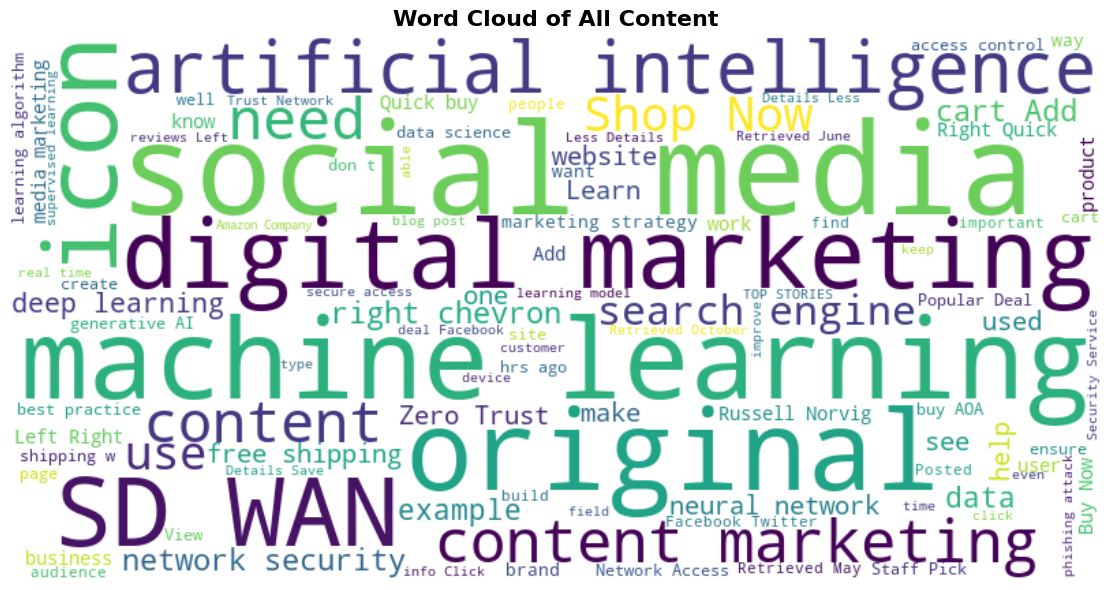

 Word cloud created successfully!

Creating quality distribution charts...


Distribution charts created successfully!


In [32]:
# Create Simple Word Clouds and Distribution Charts
print("Creating word clouds and distribution visualizations...")

try:
    from wordcloud import WordCloud
    
    # Create word cloud for all content combined
    all_text = ' '.join([text for text in content_df['body_text'] if text and len(text) > 50])
    
    if len(all_text) > 100:
        # Create word cloud
        wordcloud = WordCloud(
            width=800, 
            height=400, 
            background_color='white',
            max_words=100,
            colormap='viridis'
        ).generate(all_text)
        
        # Display word cloud
        plt.figure(figsize=(12, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title('Word Cloud of All Content', fontsize=16, fontweight='bold')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        print(" Word cloud created successfully!")
    else:
        print("Not enough text content for word cloud")

except ImportError:
    print("WordCloud library not available - skipping word cloud")

# Create quality distribution chart
print("\nCreating quality distribution charts...")

fig_quality = px.pie(
    values=features_df['quality_label'].value_counts().values,
    names=features_df['quality_label'].value_counts().index,
    title='Content Quality Distribution',
    color_discrete_sequence=['#FF6B6B', '#4ECDC4', '#45B7D1']
)

fig_quality.show()

# Create readability vs word count scatter plot
fig_scatter = px.scatter(
    features_df,
    x='flesch_reading_ease',
    y='word_count',
    color='quality_label',
    title='Readability vs Word Count by Quality',
    labels={
        'flesch_reading_ease': 'Flesch Reading Ease Score',
        'word_count': 'Word Count',
        'quality_label': 'Quality'
    },
    color_discrete_map={'High': '#FF6B6B', 'Medium': '#4ECDC4', 'Low': '#45B7D1'}
)

fig_scatter.show()

print("Distribution charts created successfully!")

In [31]:
# Feature Correlation Analysis
print("Creating feature correlation analysis...")

# Select numeric columns for correlation analysis
correlation_columns = ['word_count', 'sentence_count', 'flesch_reading_ease', 'avg_word_length']

# Calculate correlation matrix
correlation_matrix_data = features_df[correlation_columns].corr()

# Create interactive correlation heatmap
fig_corr = go.Figure(data=go.Heatmap(
    z=correlation_matrix_data.values,
    x=correlation_matrix_data.columns,
    y=correlation_matrix_data.columns,
    colorscale='RdBu',
    zmid=0,
    colorbar=dict(title="Correlation Coefficient"),
    hovertemplate='<b>%{x}</b> vs <b>%{y}</b><br>Correlation: %{z:.3f}<extra></extra>'
))

# Add correlation values as text annotations
annotations = []
for i, row in enumerate(correlation_matrix_data.values):
    for j, val in enumerate(row):
        annotations.append(dict(
            x=correlation_matrix_data.columns[j],
            y=correlation_matrix_data.columns[i],
            text=str(round(val, 2)),
            showarrow=False,
            font=dict(color='white' if abs(val) > 0.5 else 'black', size=12)
        ))

fig_corr.update_layout(
    title="Feature Correlation Matrix - Content Analysis",
    annotations=annotations,
    width=600,
    height=500
)

fig_corr.show()

# Print strongest correlations
print("\n Feature Correlations:")
correlation_pairs = []
for i in range(len(correlation_matrix_data.columns)):
    for j in range(i+1, len(correlation_matrix_data.columns)):
        corr_val = correlation_matrix_data.iloc[i, j]
        if abs(corr_val) > 0.3:  # Only show moderate to strong correlations
            correlation_pairs.append((
                correlation_matrix_data.columns[i],
                correlation_matrix_data.columns[j], 
                corr_val
            ))

# Sort by absolute correlation strength
correlation_pairs.sort(key=lambda x: abs(x[2]), reverse=True)

for feat1, feat2, corr in correlation_pairs:
    direction = " Positive" if corr > 0 else " Negative"
    print(f"  {direction}: {feat1} ↔ {feat2}: {corr:.3f}")

print("Correlation analysis completed!")

Creating feature correlation analysis...



 Feature Correlations:
   Positive: word_count ↔ sentence_count: 0.926
Correlation analysis completed!


In [44]:
# Final data export summary
print("=== FINAL DATA EXPORT SUMMARY ===")
print(f"Data files created:")
print(f"    ../data/extracted_content.csv - Parsed HTML content")
print(f"    ../data/features.csv - Extracted features with embeddings")
print(f"    ../data/duplicates.csv - Duplicate content pairs")
print(f"    ../models/quality_model.pkl - Trained classification model")

print(f"\n Processing Statistics:")
print(f"   Total pages processed: {len(features_df)}")
print(f"   Pages with valid content: {(features_df['word_count'] > 0).sum()}")
print(f"   Average word count: {features_df['word_count'].mean():.1f}")
print(f"   Average readability score: {features_df['flesch_reading_ease'].mean():.1f}")

print(f"\n Duplicate Detection Results:")
print(f"   Duplicate pairs found: {len(duplicate_pairs)}")
print(f"   Thin content pages: {thin_content_count} ({thin_content_count/len(features_df)*100:.1f}%)")
print(f"   Similarity threshold used: {SIMILARITY_THRESHOLD}")

print(f"\n Model Performance:")
print(f"   Model type: Random Forest Classifier")
print(f"   Test accuracy: {accuracy:.3f}")
print(f"   Baseline accuracy: {baseline_accuracy:.3f}")
print(f"   Performance improvement: {(accuracy - baseline_accuracy):.3f}")

print(f"\n Quality Distribution:")
for label, count in label_counts.items():
    percentage = count / len(features_df) * 100
    print(f"   {label} quality: {count} pages ({percentage:.1f}%)")

print(f"\n Key Features Used:")
for idx, row in feature_importance.iterrows():
    print(f"   {idx+1}. {row['feature']}: {row['importance']:.3f}")

print(f"\n All files successfully saved and ready for submission!")
print(f" Real-time analysis function 'analyze_url()' is ready to use!")

=== FINAL DATA EXPORT SUMMARY ===
Data files created:
    ../data/extracted_content.csv - Parsed HTML content
    ../data/features.csv - Extracted features with embeddings
    ../data/duplicates.csv - Duplicate content pairs
    ../models/quality_model.pkl - Trained classification model

 Processing Statistics:
   Total pages processed: 81
   Pages with valid content: 69
   Average word count: 29586.4
   Average readability score: 24.9

 Duplicate Detection Results:
   Duplicate pairs found: 20
   Thin content pages: 12 (14.8%)
   Similarity threshold used: 0.8

 Model Performance:
   Model type: Random Forest Classifier
   Test accuracy: 0.960
   Baseline accuracy: 0.120
   Performance improvement: 0.840

 Quality Distribution:
   Low quality: 45 pages (55.6%)
   Medium quality: 31 pages (38.3%)
   High quality: 5 pages (6.2%)

 Key Features Used:
   3. flesch_reading_ease: 0.635
   2. sentence_count: 0.158
   4. avg_word_length: 0.129
   1. word_count: 0.077

 All files successfully 